In [13]:
using Random

In [14]:
using BenchmarkTools

In [15]:
####### 1d Ising
# Metropolis

In [16]:
mutable type Measurements
    configurations::Confs # first two dim = conf, third dim = n_conf
    energies::Array{Float64, 1}
    magnetization::Array{Float64, 1}
    
    Measurements() = new()
end

LoadError: syntax: extra token "type" after end of expression

In [17]:
# Wrap everything with a module to allow redefition of type
module MC

"""
Composite type to represent a spin state
"""
mutable struct SpinState
    num_spins::Int
    s::Array{Int8,1}
    energy::Int
    tot_mag::Int
end

"""
Energy
"""
function energy(s)
    n = length(s)
    - sum((s[i] * s[ifelse(i == n, 1, i+1)] for i in 1:n))
end

"""
Total magnetization
"""
total_magnetization(s) = sum(s)

"""
Constructor
"""
function SpinState(s)
    ss = SpinState(length(s), copy(s), energy(s), total_magnetization(s))
    sanity_check(ss)
    ss
end

"""
Sanity check
"""
function sanity_check(ss)
    @assert energy(ss.s) == ss.energy
    @assert total_magnetization(ss.s) == ss.tot_mag
end

"""
Take an object of SpinState as an input and update it in place.
"""
function update!(ss, β, niters)
    min_h = -2
    max_h = 2
    s = ss.s
    n = ss.num_spins
    prob = [1/(1+exp(-2*β*h)) for h in min_h:max_h]
    for iter in 1:niters, i in 1:n
        sl = s[ifelse(i == 1, n, i-1)]
        sr = s[ifelse(i == n, 1, i+1)]
        # h = -2, 0, 2
        h = sl + sr
        si_old = s[i]
        s[i] = ifelse(rand() < prob[h-min_h+1], +1, -1)
        
        # Update observables with O(1) operations
        ss.energy += (si_old - s[i]) * h
        ss.tot_mag += (s[i] - si_old)
    end
end

end
;

In [18]:
ss = MC.SpinState(s0)
MC.update!(ss, β, niters)
MC.sanity_check(ss)

In [19]:
num_spins = 100
s0 = rand(Int8[-1, 1], num_spins)
β = 10.0
niters = 10^3

s = copy(s0)

100-element Vector{Int8}:
 -1
 -1
  1
 -1
 -1
 -1
 -1
 -1
  1
 -1
 -1
  1
 -1
  ⋮
  1
  1
 -1
  1
  1
  1
 -1
 -1
 -1
 -1
 -1
  1

In [20]:
nsweeps = 10^6
num_spins = 100

s0 = rand(Int8[-1, 1], num_spins)

Ts_mc = range(0.4, 2, length=10)

C_mc = Float64[]
for T in Ts_mc
    ss = MC.SpinState(s0)
    acc = Meas.Accumulator()
    solve!(ss, acc, 1/T, nsweeps, ntherm, interval_meas)
    E = Meas.mean(acc, "E")
    E2 = Meas.mean(acc, "E2")
    push!(C_mc, (E2-E^2)/T^2)
end

In [21]:
module Meas

struct Accumulator
    count::Dict{String,UInt64}
    data::Dict{String,Any}
end

"""
Constructor
"""
function Accumulator()
    Accumulator(Dict{String,UInt64}(), Dict{String,Any}())
end

"""
Add a sample
"""
function add!(acc::Accumulator, name::String, data)
    if haskey(acc.count, name)
        acc.count[name] += 1
        acc.data[name] += data
    else
        acc.count[name] = 1
        acc.data[name] = copy(data)
    end
end

"""
Compuate mean
"""
function mean(acc::Accumulator, name::String)
    return acc.data[name]/acc.count[name]
end

end


# Perform some tests
let
    acc = Meas.Accumulator()
    Meas.add!(acc, "obs1", ones(4))
    Meas.add!(acc, "obs1", fill(2.0, 4))
    Meas.add!(acc, "obs2", ones(4))
    Meas.add!(acc, "obs2", ones(4))
    @assert Meas.mean(acc, "obs1") ≈ fill(1.5, 4)
    @assert Meas.mean(acc, "obs2") ≈ ones(4)
end

In [22]:
function solve!(ss, acc, β, nsweeps, ntherm, interval_meas)
    if mod(nsweeps, interval_meas) != 0
        error("nsweeps cannot be divided by interval_meas!")
    end
    
    # Thermalization steps
    MC.update!(ss, β, ntherm)
    
    # Measurement steps
    for imeas in 1:(nsweeps÷interval_meas)
        MC.update!(ss, β, interval_meas)
        Meas.add!(acc, "E", Float64(ss.energy))
        Meas.add!(acc, "E2", Float64(ss.energy)^2)
    end
    MC.sanity_check(ss)
end

nsweeps = 100
interval_meas = 10
ntherm = nsweeps÷10
β = 1.0

1.0

In [23]:
using Plots

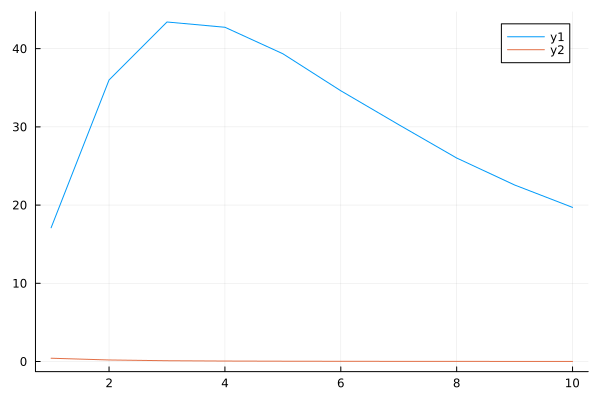

In [26]:
plot(C_mc)
exact_C(T) = 1/(T * cosh(1/T))^2
plot!([exact_C(x) for x in 1:10])

In [36]:
s0 = rand(Int8[-1, 1], num_spins)

solve!(s0, 0, 1/2, 10^3, nsweeps÷10, 10)

LoadError: type Array has no field s

In [ ]:
heatmap()

[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
[ Info: Installing matplotlib via the Conda matplotlib package...
[ Info: Running `conda install -y matplotlib` in root environment


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/matthewmeeker/.julia/conda/3/x86_64

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.0.9               |       hb7f2c08_8          19 KB  conda-forge
    brotli-bin-1.0.9           |       hb7f2c08_8          17 KB  conda-forge
    contourpy-1.0.7            |  py310ha23aa8a_0         204 KB  conda-forge
    cycler-0.11.0              |     pyhd8ed1ab_0          10 KB  conda-forge
    fonttools-4.39.3           |  py310h90acd4f_0         2.0 MB  conda-forge
    freetype-2.12.1            |       h3f81eb7_1         586 KB  conda-forge
    kiwisolver-1.4.4           |  py310ha23aa8a_1          63 KB  conda-forge
    lcms2-2.15                 |       h2dcdeff_1         222 KB  conda-forge
    lerc-4.0.0                 |       hb486fe8_0         2

 ... (more hidden) ...

openjpeg-2.5.0       | 322 KB    | #7                                   |   5% 


libjpeg-turbo-2.1.5. | 448 KB    | #2                                   |   4% 
lerc-4.0.0           | 284 KB    | ##                                   |   6% 



libtiff-4.5.0        | 384 KB    | #5                                   |   4% 


libdeflate-1.18      | 65 KB     | #################################### | 100% 




pillow-9.5.0         | 44.0 MB   |                                      |   0% 





tornado-6.2          | 664 KB    | 8                                    |   2% 






libpng-1.6.39        | 265 KB    | ##1                                  |   6% 







lcms2-2.15           | 222 KB    | ##5                                  |   7% 








contourpy-1.0.7      | 204 KB    | ##8                                  |   8% 

openjpeg-2.5.0       | 322 KB    | #################################### | 100% 









xorg-libxau-1.0.9    | 11 KB     | ##############

matplotlib-3.7.1     | 8 KB      | #################################### | 100% 





















libbrotlicommon-1.0. | 64 KB     | #################################### | 100% 





















libbrotlicommon-1.0. | 64 KB     | #################################### | 100% 






















xorg-libxdmcp-1.1.3  | 17 KB     | #################################### | 100% 




pillow-9.5.0         | 44.0 MB   | #################2                   |  48% 





tornado-6.2          | 664 KB    | #################################### | 100% 





tornado-6.2          | 664 KB    | #################################### | 100% 

























libbrotlidec-1.0.9   | 33 KB     | #################################### | 100% 

























libbrotlidec-1.0.9   | 33 KB     | #################################### | 100% 




pillow-9.5.0         | 44.0 MB   | #####################4               |  60% 
























python-dateutil-2.8. | 240 KB    | #########

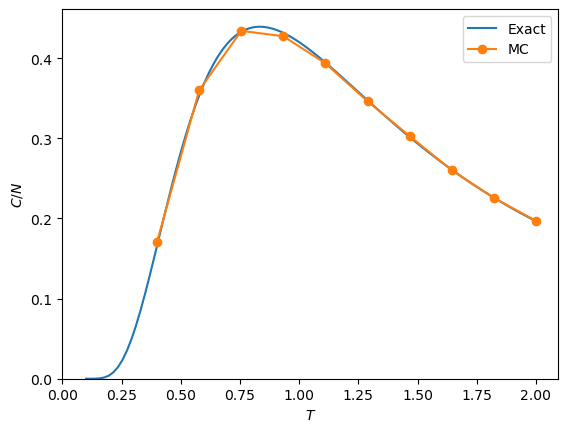

PyObject <matplotlib.legend.Legend object at 0x11ea3f100>

In [27]:
using PyPlot
Ts = range(0.1, 2, length=100)
exact_C(T) = 1/(T * cosh(1/T))^2
plt.plot(Ts, exact_C.(Ts), label="Exact")
plt.plot(Ts_mc, C_mc ./ num_spins, label="MC", marker="o")
plt.xlabel(raw"$T$")
plt.ylabel(raw"$C/N$")
plt.xlim([0, nothing])
plt.ylim([0, nothing])
plt.legend()

In [2]:
# Wolff

In [3]:
######### 2d Ising